# Пункт 1
Уберем деление на N, так как это константа

$ -F(w) = \frac{1}{N}\sum_{i=1}^{N} y_i \log(\sigma_w(x_i)) + (1 - y_i) \log(1 - \sigma_w(x_i)) =$

$ \frac{1}{N} y^T \log(\frac{\sigma_w(X)}{1 - \sigma_w(X)}) + 1^T \log(1 - \sigma_w(X)) = $

$ \frac{1}{N} y X w + 1 \log(1 - \sigma_w(X)) = \frac{1}{N} y X w - 1 \log(1 + e^{X w})$

$ \frac{\partial \log(\sigma_w(x_i))}{\partial w^T} = \frac{1}{\sigma_w(x_i)} \frac{\partial \sigma_w(x_i)}{\partial w^T} = (1 - \sigma_w(x_i)) x_i^T $

$ \frac{\partial \log(1 - \sigma_w(x_i))}{\partial w^T} = -\frac{1}{1 - \sigma_w(x_i)} \frac{\partial \sigma_w(x_i)}{\partial w^T} = -\sigma_w(x_i) x_i^T $

$ \nabla F_i = - y_i \frac{\partial \log(\sigma_w(x_i))}{\partial w^T} - (1 - y) \frac{\partial \log(1 - \sigma_w(x_i))}{\partial w^T} = -y_i (1 - \sigma_w(x_i)) x_i^T + (1-y_i) \sigma_w(x_i) x_i^T = x_i^T (\sigma_w(x_i) - y_i) $

$ \nabla F = X^T (\sigma_w(X) - y) $

$ \nabla^2 F = X^T \sigma_w(X) (1 - \sigma_w(X)) X$

In [6]:
import os
import numpy as np
import scipy
import timeit
import time
import copy
from matplotlib import pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

DATA_PATH = "../../2/data"

In [2]:
def scale_data(X_tr, X_te, y_tr, y_te):
    ss = StandardScaler().fit(X_tr)
    return ss.transform(X_tr), ss.transform(X_te), y_tr, y_te

def get_dataset(name='synthetic'):
    def svm_data(path):
        train_path = os.path.join(DATA_PATH, "a1a.txt")
        data = load_svmlight_file(train_path)
        y = np.array(data[1] > 0, dtype=np.int32).reshape(-1, 1)
        return data[0], y
    
    if name == "a1a":
        data_path = os.path.join(DATA_PATH, "a1a.txt")
        return svm_data(data_path)
    elif name == "breast-cancer":
        data_path = os.path.join(DATA_PATH, "breast-cancer.txt")
        return svm_data(data_path)
    elif name == "synthetic":
        a, b = np.random.random() * 2 - 1, np.random.random() * 2 - 1
        x = np.random.normal(size=1000).reshape(-1, 1)
        y = np.array((a * x + b) >= 0, dtype=np.int32)
        X = scipy.sparse.csr_matrix(x)
        return X, y
    else:
        raise ValueError("name should be one of ['a1a', 'breast-cancer', 'synthetic']")

In [3]:
def gradient_checker(J, grad_J, theta, eps=1e-4, rtol=1e-5):
    it = np.nditer(theta, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        num_grad = 0
        rel_tol = 1
        left, right = np.copy(theta), np.copy(theta)
        left[ix] -= eps
        right[ix] += eps
        num_grad = (J(right) - J(left)) / (2 * eps)
        rel_tol = np.abs(num_grad - grad_J(theta)) / (1. + np.minimum(np.abs(num_grad), np.abs(grad_J(theta))))
#         print(num_grad)
#         print(grad_J(theta)[0])
#         print(rel_tol[0])

        if np.all(rel_tol > rtol):
            print(f'Incorrect gradient for the axis {str(ix)}')
            return
        it.iternext()
    print(f'Gradient check passed')

In [262]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def add_ones(X):
    return scipy.sparse.hstack((X, np.ones(X.shape[0]).reshape(-1, 1)))


# def np_eq(a1, a2):
#     try:
#         return a1 == a2
#     except ValueError:
#         l = []
#         for b1, b2 in zip(a1, a2):
#             eq = np_eq(b1, b2)
#             if isinstance(eq, bool):
#                 l.append(eq)
#             else:
#                 l.append(all(eq))
#         return all(np.array(l))


def calls_count_cache(oracle):
    def wrapper(*args, **kwargs):
#         if np_eq(wrapper.arg, (args, kwargs)):
#             return wrapper.value
#         wrapper.arg = (args, kwargs)
#         wrapper.value = oracle(*args, **kwargs)
        wrapper.calls += 1
        return oracle(*args, **kwargs)
    wrapper.calls = 0
#     wrapper.arg = None
#     wrapper.value = None
    return wrapper


default_reg = 1e-4


def oracle_0_for_minimize(X, y, w):
    eps = 1e-6
    if w.shape != (X.shape[1], 1):
        w = np.array(w).reshape(-1, 1)
    n = y.shape[0]
    z = X @ w
    return (-(y.T @ z - np.sum(np.logaddexp(0, z))) / n + default_reg * w.T @ w)[0, 0]


@calls_count_cache
def oracle_0(X, y, w, reg=default_reg, eps=1e-10):
    n = y.shape[0]
    z = X @ w
    return (-(y.T @ z - np.sum(np.logaddexp(0, z))) / n + reg * w.T @ w)[0, 0]


@calls_count_cache
def oracle_1(X, y, w, reg=default_reg):
    n = y.shape[0]
    return X.T @ (sigmoid(X @ w) - y) / n + 2 * reg * w


@calls_count_cache
def oracle_2(X, y, w, reg=default_reg):
    n = y.shape[0]
    z = sigmoid(X @ w)
    return X.T @ np.multiply(np.eye(X.shape[0]), np.multiply(z, (1 - z))) @ X / n + 2 * reg * np.eye(len(w))

In [7]:
X, y = get_dataset('a1a')
w = (np.random.rand(X.shape[1]) * 2 - 1).reshape(-1, 1)
f = lambda w: oracle_0(X, y, w, eps=0)
df = lambda w: oracle_1(X, y, w)
ddf = lambda w: oracle_2(X, y, w)
gradient_checker(f, df, w, eps=1e-4, rtol=1e-6)
gradient_checker(df, ddf, w, eps=1e-4, rtol=1e-7)

Gradient check passed
Gradient check passed


In [8]:
def polynom(coeffs):
    @calls_count_cache
    def polynom_value(x):
        v = 0
        # index in coeffs is monom degree
        for c in coeffs[::-1]:
            v = v * x + c
        return v
    return polynom_value

def generate_polynom(deg=2):
    cs = [np.random.random() * 2 - 1 for i in range(deg + 1)]
    poly = polynom(cs)
    poly.coeffs = cs
    return poly

In [9]:
def golden_search(f, left, right, eps):
    phi = (1 + 5 ** 0.5) / 2
    resphi = 2 - phi
    x1 = left + resphi * (right - left)
    x2 = right - resphi * (right - left)
    f1 = f(x1)
    f2 = f(x2)
    while right - left > eps:
        if f1 < f2:
            right = x2
            x2 = x1
            f2 = f1
            x1 = left + resphi * (right - left)
            f1 = f(x1)
        else:
            left = x1
            x1 = x2
            f1 = f2
            x2 = right - resphi * (right - left)
            f2 = f(x2)
    xmin = (x1 + x2) / 2
    return xmin

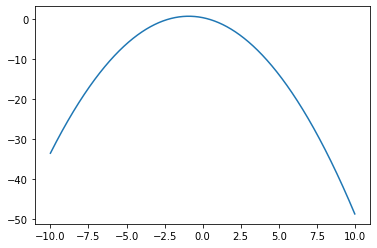

Method: My golden
Arg min: 9.999996678126024
Calls num: 33

Method: Brent
Arg min: 4.988310990139755e+154
Calls num: 756

Method: Scipy Golden
Arg min: 2.0836913439682972e+154
Calls num: 760





/Users/aleksandr.khvorov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


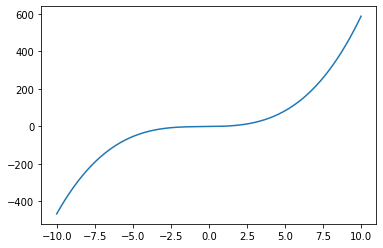

Method: My golden
Arg min: -9.999996678126024
Calls num: 33

Method: Brent
Arg min: -1.1967560553817162e+103
Calls num: 509

Method: Scipy Golden
Arg min: -7.015234161318998e+102
Calls num: 512





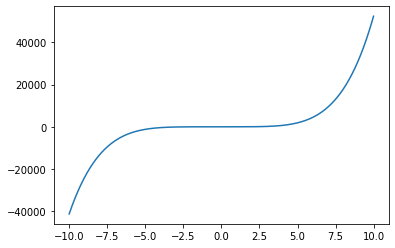

Method: My golden
Arg min: -9.999996678126024
Calls num: 33

Method: Brent
Arg min: -1.3074574160354425e+62
Calls num: 313

Method: Scipy Golden
Arg min: -5.226232395999937e+61
Calls num: 317





In [10]:
def info(name, xmin, calls):
    print("Method:", name)
    print("Arg min:", xmin)
    print("Calls num:", calls)
    print()

bounds = (-10, 10)
eps = 1e-5
for deg in [2, 3, 5]:
    poly = generate_polynom(deg)
    xs = np.arange(bounds[0], bounds[1], 0.01)
    plt.plot(xs, [poly(x) for x in xs])
    plt.show()
    poly.calls = 0
    res = golden_search(poly, bounds[0], bounds[1], eps)
    info("My golden", res, poly.calls)
    res = scipy.optimize.minimize_scalar(poly, bracket=bounds, bounds=bounds, method='Brent', tol=eps)
    info("Brent", res.x, res.nfev)
    res = scipy.optimize.minimize_scalar(poly, bracket=bounds, bounds=bounds, method='Golden', tol=eps)
    info("Scipy Golden", res.x, res.nfev)
    print()
    print()

In [106]:
def gd(X, y, w, oracles, **params):
    return oracles[1](X, y, w), params

def newton(X, y, w, oracles, **params):
    cho_fac = scipy.linalg.cho_factor(oracles[2](X, y, w))
    return scipy.linalg.cho_solve(cho_fac, oracles[1](X, y, w)), params

In [238]:
def hessian_times_vector(X, y, w, vector, reg=1):
    n = y.shape[0]
    z = sigmoid(X @ w)
    B = np.multiply(np.eye(n), np.multiply(z, (1 - z)))
    res = X.T @ (B @ (X @ vector)) / n + 2 * reg * vector
    return res

def newton_free(X, y, w, oracles, policy='const', eta=0.5, iters=100, eps=1e-8):
    params = {'policy': policy, 'eta': eta, 'iters': iters, 'eps': eps}
    grad = oracles[1](X, y, w)
    grad_norm = np.linalg.norm(grad)
    tol = grad_norm * eta
    if policy == 'sqrtGradNorm':
        tol = tol * min(grad_norm ** 0.5, 0.5)
    elif policy == 'gradNorm':
        tol = tol * min(grad_norm, 0.5)
    z = np.zeros_like(w)
    g = hessian_times_vector(X, y, w, z) + grad
    d = -g
    Hd = hessian_times_vector(X, y, w, d)
    for i in range(iters):
        gamma = (g.T @ g / (d.T @ Hd))[0, 0]
        z = z + gamma * d
        g_n = g + gamma * Hd
        if np.linalg.norm(g_n) < tol:
            return -z, params
        beta = ((g_n.T @ g_n) / (g.T @ g))[0, 0]
        d = -g + beta * d
        g = g_n
        Hd = hessian_times_vector(X, y, w, d)
    return z, params

In [239]:
def bfgs(X, y, w, oracles, prev_w=None, prev_grad=None, prev_B=None):
    grad = oracles[1](X, y, w)
    if prev_B is None:
        prev_B = np.eye(len(w))
        prev_w = np.zeros_like(w)
        prev_grad = np.zeros_like(grad)
    s = w - prev_w
    y = grad - prev_grad
    first = (s.T @ y + y.T @ prev_B @ y) * (s @ s.T) / ((s.T @ y)[0, 0] ** 2)
    second = (prev_B @ y @ s.T + s @ y.T @ prev_B) / ((s.T @ y)[0, 0])
    B = prev_B + first - second
    params = {'prev_B': B, 'prev_w': w, 'prev_grad': grad}
    direction = B @ grad
    return direction, params

In [245]:
def lbfgs(X, y, w, oracles, history_size=5, ss=None, ys=None, prev_w=None, prev_grad=None):
    grad = oracles[1](X, y, w)
    if ss is None:
        prev_w = np.array(w)
        prev_grad = np.array(grad)
        ss = [prev_w] * history_size
        ys = [prev_grad] * history_size
    else:
        ss = ss[1:] + [w - prev_w]
        ys = ys[1:] + [grad - prev_grad]
    
    q = grad
    aa = [0] * history_size
    
    for i in range(history_size):
        s = ss[history_size - i - 1]
        y = ys[history_size - i - 1]
        a = s.T @ q / (y.T @ s)
        aa[history_size - i - 1] = a
        q = q - a * y
        
    gamma = ss[0].T @ ys[0] / (ys[0].T @ ys[0])
    H = gamma * np.eye(len(w))
    z = H @ q
    for i in range(history_size):
        s = ss[i]
        y = ys[i]
        a = aa[i]
        b = y.T @ z / (y.T @ s)
        z = z + s * (a - b)
    
    params = {'history_size': history_size, 'ss': ss, 'ys': ys, 'prev_w': w, 'prev_grad': grad}
    return z, params

In [12]:
def step_oracle_0(X, y, w, oracle_0, direction):
    return lambda step: oracle_0(X, y, w - step * direction)

def step_oracle_1(X, y, w, oracle_1, direction):
    return lambda step: (-direction.T @ oracle_1(X, y, w - step * direction))[0, 0]


def golden(X, y, w, oracles, direction, guess=10, init=10, eps=1e-6):
    return golden_search(step_oracle_0(X, y, w, oracles[0], direction), 0, init, eps)

def brent(X, y, w, oracles, direction, guess=10, init=10, eps=1e-6):
    bounds = (0, init)
    res = scipy.optimize.minimize_scalar(step_oracle_0(X, y, w, oracles[0], direction), 
                                         bracket=bounds, bounds=bounds, method='Brent', tol=eps)
    return res.x

def armijo(X, y, w, oracles, direction, guess=10, init=10, c=0.01):
    step_func = step_oracle_0(X, y, w, oracles[0], direction)
    zero_value = oracles[0](X, y, w)
    zero_grad = step_oracle_1(X, y, w, oracles[1], direction)(0)
    while step_func(guess) > zero_value + c * guess * zero_grad:
        guess /= 2
    return guess

def wolfe(X, y, w, oracles, direction, guess=10, init=10, c1=0.001, c2=0.9):
    bounds = (0, init)
    res = scipy.optimize.linesearch.scalar_search_wolfe2(step_oracle_0(X, y, w, oracles[0], direction),
                                                         step_oracle_1(X, y, w, oracles[1], direction),
                                                         c1=c1, c2=c2)[0]
    return res

def lipschitz(X, y, w, oracles, direction, guess=10, init=10):
    step_func = step_oracle_0(X, y, w, oracles[0], direction)
    zero_value = step_func(0)
    zero_grad = step_oracle_1(X, y, w, oracles[1], direction)(0)
    while step_func(guess) > zero_value + 0.5 * guess * zero_grad:
        guess /= 2
    return guess

In [13]:
def grad_ratio(grad, init_grad):
    grad = np.abs(grad)
    grad = grad.T @ grad
    init_grad = np.abs(init_grad)
    init_grad = init_grad.T @ init_grad
    return (grad / init_grad)[0, 0]

In [148]:
def optimize(X, y, w, oracles, compute_direction, ls_method, max_iters=100, eps=1e-5):
    get_direction, dir_params = compute_direction
    compute_step, ls_params = ls_method
    init_grad = oracles[1](X, y, w)
    opt_arg = scipy.optimize.minimize(lambda x: oracle_0_for_minimize(X, y, x), w).x.reshape(-1, 1)
    opt_value = oracles[0](X, y, opt_arg)
    r1 = [abs(opt_value - oracles[0](X, y, w))]
    r2 = [1]
    times = [0]
    calls = [0]
    start_time = time.process_time() 
    step = 50
    direction = None
    not_converge_at_least_once = False
    for oracle in oracles:
        oracle.calls = 0
    for iter_num in range(max_iters):
        if r2[-1] < eps:
            iter_num -= 1
            break
        direction, dir_params = get_direction(X, y, w, oracles, **dir_params)
        step = compute_step(X, y, w, oracles, direction, 2 * step, 100, *ls_params)
        if step is None:
            if not not_converge_at_least_once:
                print("Line search is not converges")
            not_converge_at_least_once = True
            step = 0.
        if oracles[0](X, y, w) is None or np.isnan(oracles[0](X, y, w)):
            w = opt_arg
            print(iter_num, direction)
            break
#         print(step)
#         print(step * direction)
#         print()
        w = w - step * direction
        r1.append(abs(opt_value - oracles[0](X, y, w)))
        r2.append(grad_ratio(oracles[1](X, y, w), init_grad))
        times.append(time.process_time() - start_time)
        calls.append(sum(oracle.calls for oracle in oracles))
#     print("Opt value", opt_value, "finded value", oracles[0](X, y, w))
    return w, r1, r2, times, list(range(iter_num + 2)), calls

In [77]:
oracles = [oracle_0, oracle_1, oracle_2]
# X, y = get_dataset('a1a')
X, y = get_dataset('synthetic')
X = add_ones(X)
w = (np.random.rand(X.shape[1]) * 2 - 1).reshape(-1, 1)
res = optimize(X, y, w, oracles, gd, (lipschitz, tuple()), max_iters=100)
# print(oracles[0](X, y, res[0]))

In [263]:
oracles = [oracle_0, oracle_1, oracle_2]

def draw_multy_plots(opt_res, column_ind, data_name="a1a"):
    fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0})
    (ax1, ax2, ax3), (ax4, ax5, ax6) = axs
    init_method, optimize_method, line_search = opt_res[0, :3]
    
    title = "Optimize"
    if column_ind != 1:
        title += f' by {optimize_method}'
    if column_ind != 2:
        title += f' with {line_search} line search method'
    title += f' on {data_name} data'
    if column_ind != 0:
        title += f' with {init_method} init'
    fig.suptitle(title)
    
    for line in opt_res:
        label = line[column_ind]
        init_method, optimize_method, line_search, x, r1, r2, times, iters, calls = line
        lr1 = np.log(r1)
        lr2 = np.log(r2)
        ax1.plot(times, lr1, label=label)
        ax2.plot(iters, lr1, label=label)
        ax3.plot(calls, lr1, label=label)
        ax4.plot(times, lr2, label=label)
        ax5.plot(iters, lr2, label=label)
        ax6.plot(calls, lr2, label=label)
    
    ax1.set_ylabel("|F(wk) - F(w*)|")
    ax4.set_ylabel("squared gradients ratio")
    ax4.set_xlabel("time, s")
    ax5.set_xlabel("iterations")
    ax6.set_xlabel("oracle calls")
    
    handles, labels = ax6.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')
#     fig.legend(handles, labels, loc=((1, 2), (3, 2)))

    for ax in axs.flat:
        ax.label_outer()
    plt.show()
    
def draw_cmp_by_column(data, data_name, column_id, init='uniform', opt_method='GD', ls_method='BRENT'):
    filter_vec = np.ones(len(data))
    for i, value in enumerate([init, opt_method, ls_method]):
        if i != column_id:
            filter_vec = np.logical_and(filter_vec, data[:, i] == value)
    filtered_data = data[filter_vec]
    draw_multy_plots(filtered_data, column_ind=column_id, data_name=data_name)
    
def optimize_all_methods(dataset, eps=1e-5):
    init_methods = ['uniform', 'normal']
    opt_names = ['GD', 'NEWTON', 'NEWTON-FREE', 'BFGS', 'L-BFGS (1)', 'L-BFGS (5)', 'L-BFGS (20)']
    opt_methods = [gd, newton, newton_free, bfgs, lbfgs, lbfgs, lbfgs]
    opt_methods_params = [{}, {}, {'iters': 30, 'policy': 'const'}, {}, {'history_size': 1}, {'history_size': 5}, {'history_size': 20}]
    ls_names = ["GOLDEN", "BRENT", "ARMIJO (0.005)", "ARMIJO (0.01)", "ARMIJO (0.05)", 
                "WOLFE (0.0001, 0.9)", "WOLFE (0.001, 0.9)", "WOLFE (0.01, 0.9)", "WOLFE (0.001, 0.1)", "LIPSCHITZ"]
    ls_methods = [golden, brent, armijo, armijo, armijo, wolfe, wolfe, wolfe, wolfe, lipschitz]
    t = tuple()
    ls_methods_params = [t, t, (0.005,), (0.01,), (0.05,), (0.0001, 0.9), (0.001, 0.9), (0.01, 0.9), (0.001, 0.1), t]
    X, y = dataset
    ress = []
    for init_method in init_methods:
        if init_method == 'uniform':
            w = (np.random.rand(X.shape[1]) * 2 - 1).reshape(-1, 1)
        elif init_method == 'normal':
            w = np.random.normal(scale=1, size=X.shape[1]).reshape(-1, 1)
        for opt_name, opt_method in zip(opt_names, zip(opt_methods, opt_methods_params)):
            for ls_name, ls_method in zip(ls_names, zip(ls_methods, ls_methods_params)):
                opt_res = optimize(X, y, copy.deepcopy(w), oracles, opt_method, ls_method, max_iters=100, eps=eps)
                dir_params_line = str(opt_method[1].values()) if opt_method[1] else ""
#                 ls_params_line = f" ({', '.join(map(str, ls_method[1]))})" if ls_method[1] else ""
                ls_params_line = str(ls_method[1]) if ls_method[1] else ""
                line = [init_method, opt_name, ls_name] + list(opt_res)
                ress.append(line)
    return ress


def prepare_dataset(data_name):
    X, y = get_dataset(data_name)
    X = add_ones(X)
    return X, y 

In [67]:
synthetic_data = prepare_dataset('synthetic')
a1a_data = prepare_dataset('a1a')
cancer_data = prepare_dataset('breast-cancer')

In [266]:
synthetic_opt_res = optimize_all_methods(synthetic_data)
synthetic_opt_res = np.array(synthetic_opt_res)

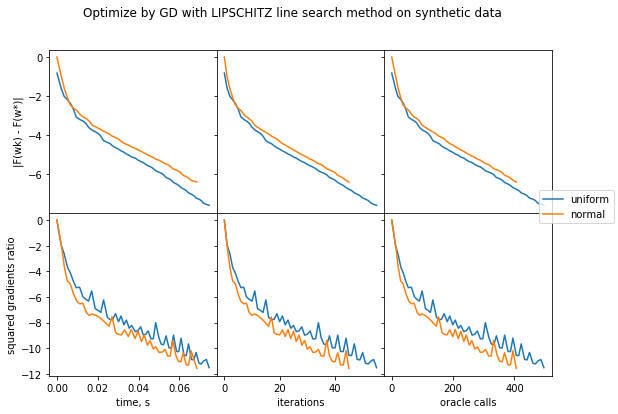

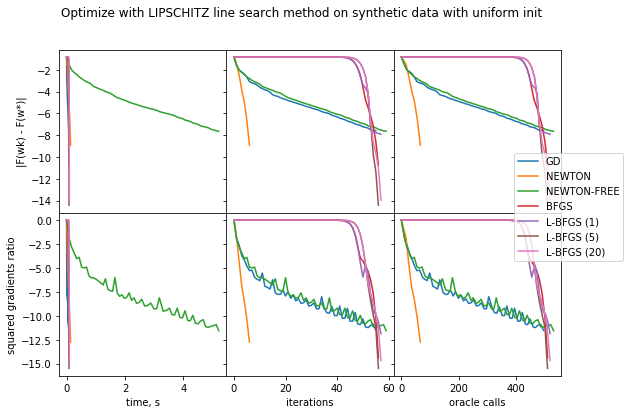

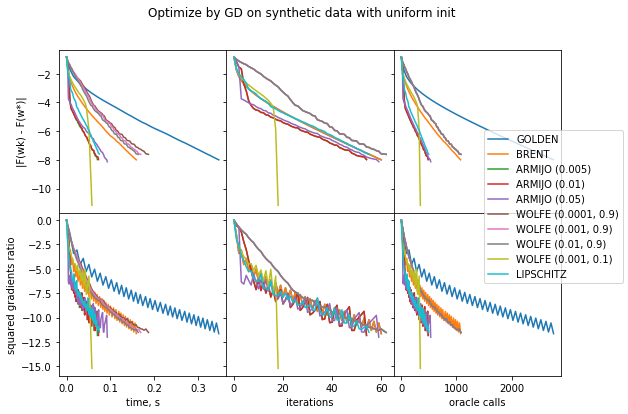

In [265]:
for i in range(3):
    draw_cmp_by_column(synthetic_opt_res, "synthetic", column_id=i, init='uniform', opt_method='GD', ls_method='LIPSCHITZ')

In [255]:
a1a_opt_res = optimize_all_methods(a1a_data)
a1a_opt_res = np.array(a1a_opt_res)

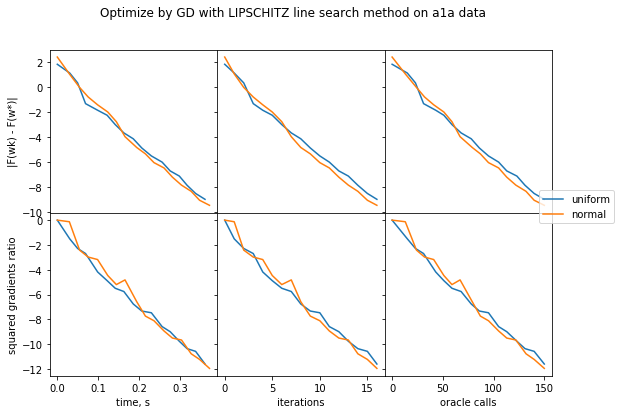

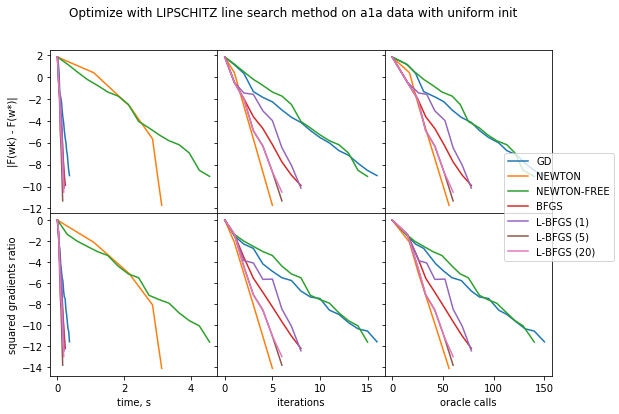

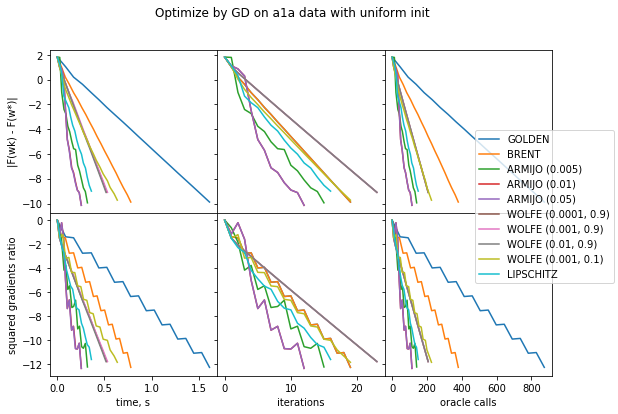

In [256]:
for i in range(3):
    draw_cmp_by_column(a1a_opt_res, "a1a", column_id=i, init='uniform', opt_method='GD', ls_method='LIPSCHITZ')

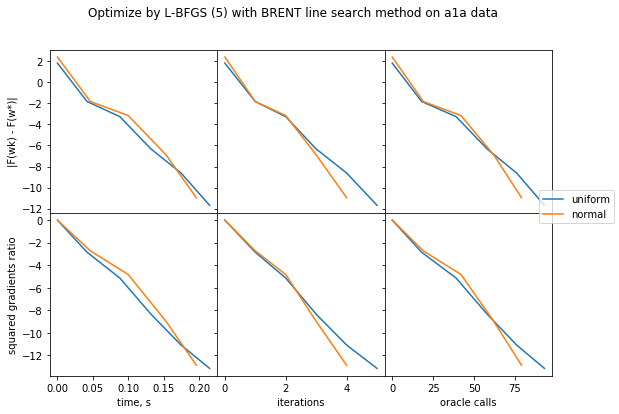

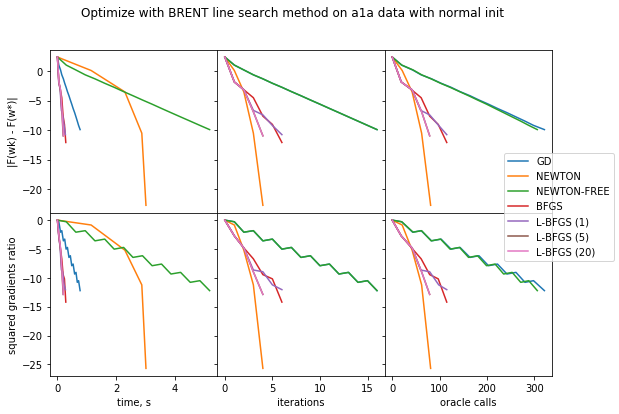

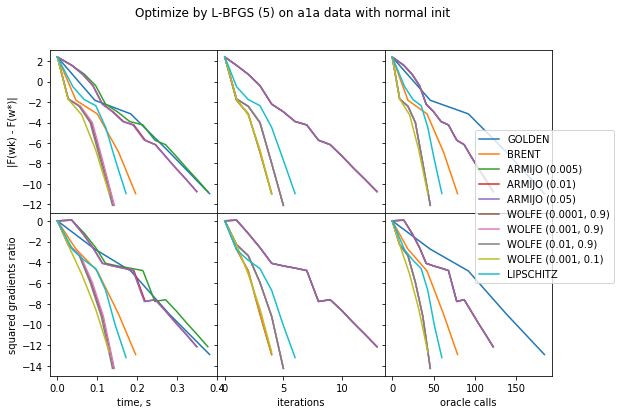

In [258]:
for i in range(3):
    draw_cmp_by_column(a1a_opt_res, "a1a", column_id=i, init='normal', opt_method='L-BFGS (5)', ls_method='BRENT')

In [259]:
cancer_opt_res = optimize_all_methods(cancer_data)
cancer_opt_res = np.array(cancer_opt_res)

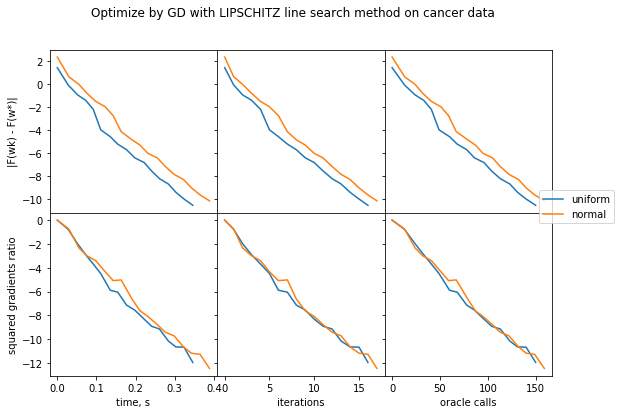

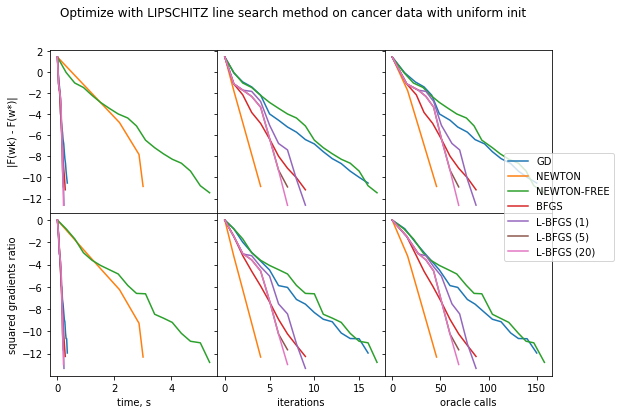

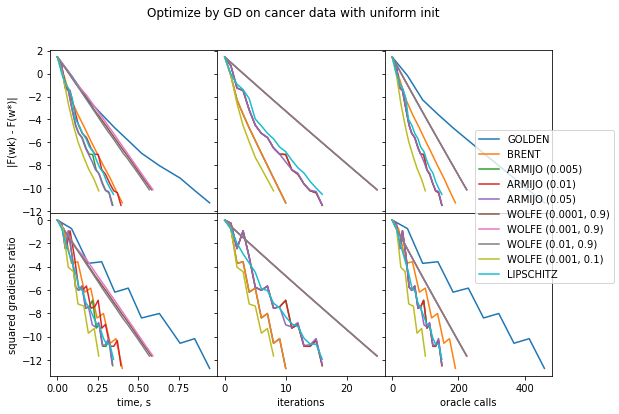

In [260]:
for i in range(3):
    draw_cmp_by_column(cancer_opt_res, "cancer", column_id=i, init='uniform', opt_method='GD', ls_method='LIPSCHITZ')

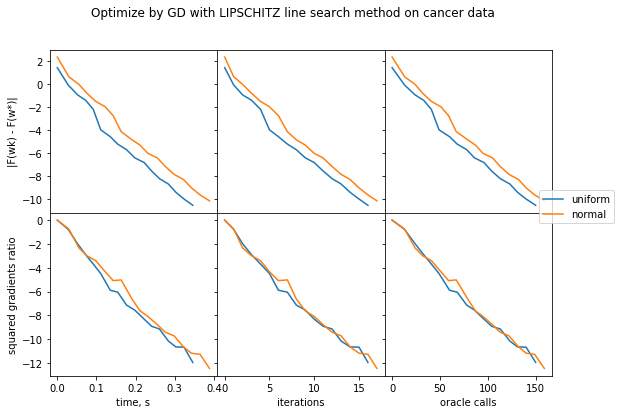

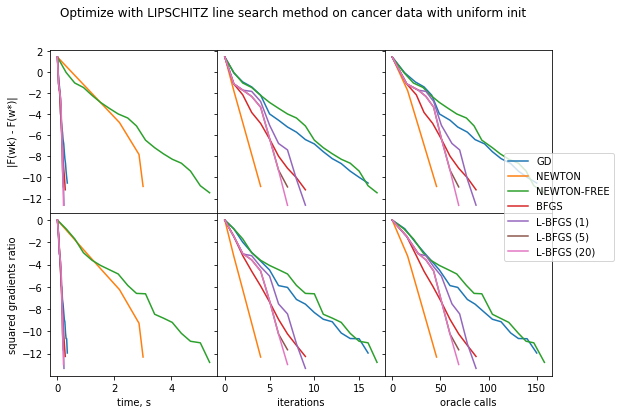

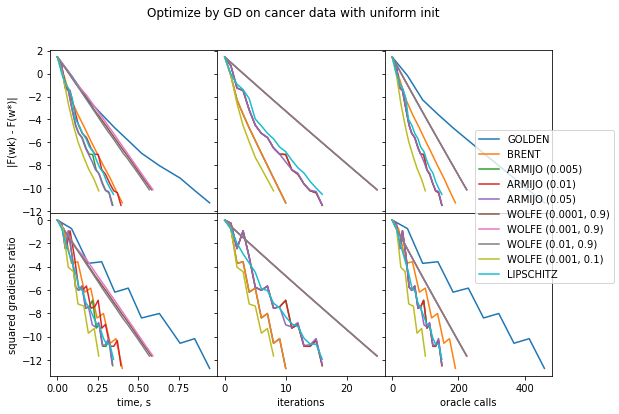

In [261]:
for i in range(3):
    draw_cmp_by_column(cancer_opt_res, "cancer", column_id=i, init='normal', opt_method='L-BFGS (5)', ls_method='BRENT')

# Анализ

## Инициализация

Способ инициализации не очень сильно влиял на результат оптимизации. Инициализация из нормального распределения иногда дает результат немного лучше, но не существенно.

## Line-search алгоритмы

Golden search показал себя хуже всего. Также в методе Вольфе большую роль играют параметры. При некоторых параметрах он работает хуже всех, но также он модет работать и лучше остальных.

## Выбор направления

Лучше всего работает метод Ньютона, но в жизни его редко можно применить, поэтому методы (L-)BFGS похожи на хорошую его замену, так как не сильно уступают в точности, зато сильно лучше по производительности.